In [1]:
import pandas as pd

In [2]:
from pathlib import Path
import tensorflow as tf

In [8]:
train_dir = 'train'
test_dir = 'test'

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2  # 20% of data for validation
)

In [10]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 1609 images belonging to 10 classes.


In [12]:
val_images = train_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 400 images belonging to 10 classes.


In [13]:
test_images = test_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 500 images belonging to 10 classes.


In [21]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

In [22]:
pretrained_model.trainable = False

In [23]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

In [24]:
model = tf.keras.Model(inputs, outputs)

In [25]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )]
)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 1.1018 - accuracy: 0.6426

C:\Users\sowmya\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


51/51 [==============================] - 60s 1s/step - loss: 1.1018 - accuracy: 0.6426 - val_loss: 0.5004 - val_accuracy: 0.8325
Epoch 2/100
51/51 [==============================] - 38s 750ms/step - loss: 0.3780 - accuracy: 0.8813 - val_loss: 0.3173 - val_accuracy: 0.8875
Epoch 3/100
51/51 [==============================] - 37s 722ms/step - loss: 0.2119 - accuracy: 0.9360 - val_loss: 0.2811 - val_accuracy: 0.9025
Epoch 4/100
51/51 [==============================] - 40s 784ms/step - loss: 0.1078 - accuracy: 0.9727 - val_loss: 0.2545 - val_accuracy: 0.9025
Epoch 5/100
51/51 [==============================] - 41s 806ms/step - loss: 0.0550 - accuracy: 0.9907 - val_loss: 0.2096 - val_accuracy: 0.9250
Epoch 6/100
51/51 [==============================] - 38s 742ms/step - loss: 0.0266 - accuracy: 0.9981 - val_loss: 0.2160 - val_accuracy: 0.9125
Epoch 7/100
51/51 [==============================] - 37s 735ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 0.2192 - val_accuracy: 0.9150
Epoch 8

In [27]:
model.save('classify.h5')

C:\Users\sowmya\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 87.20%


In [29]:
import numpy as np

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
import pandas as pd

In [33]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

16/16 [==============================] - 11s 626ms/step


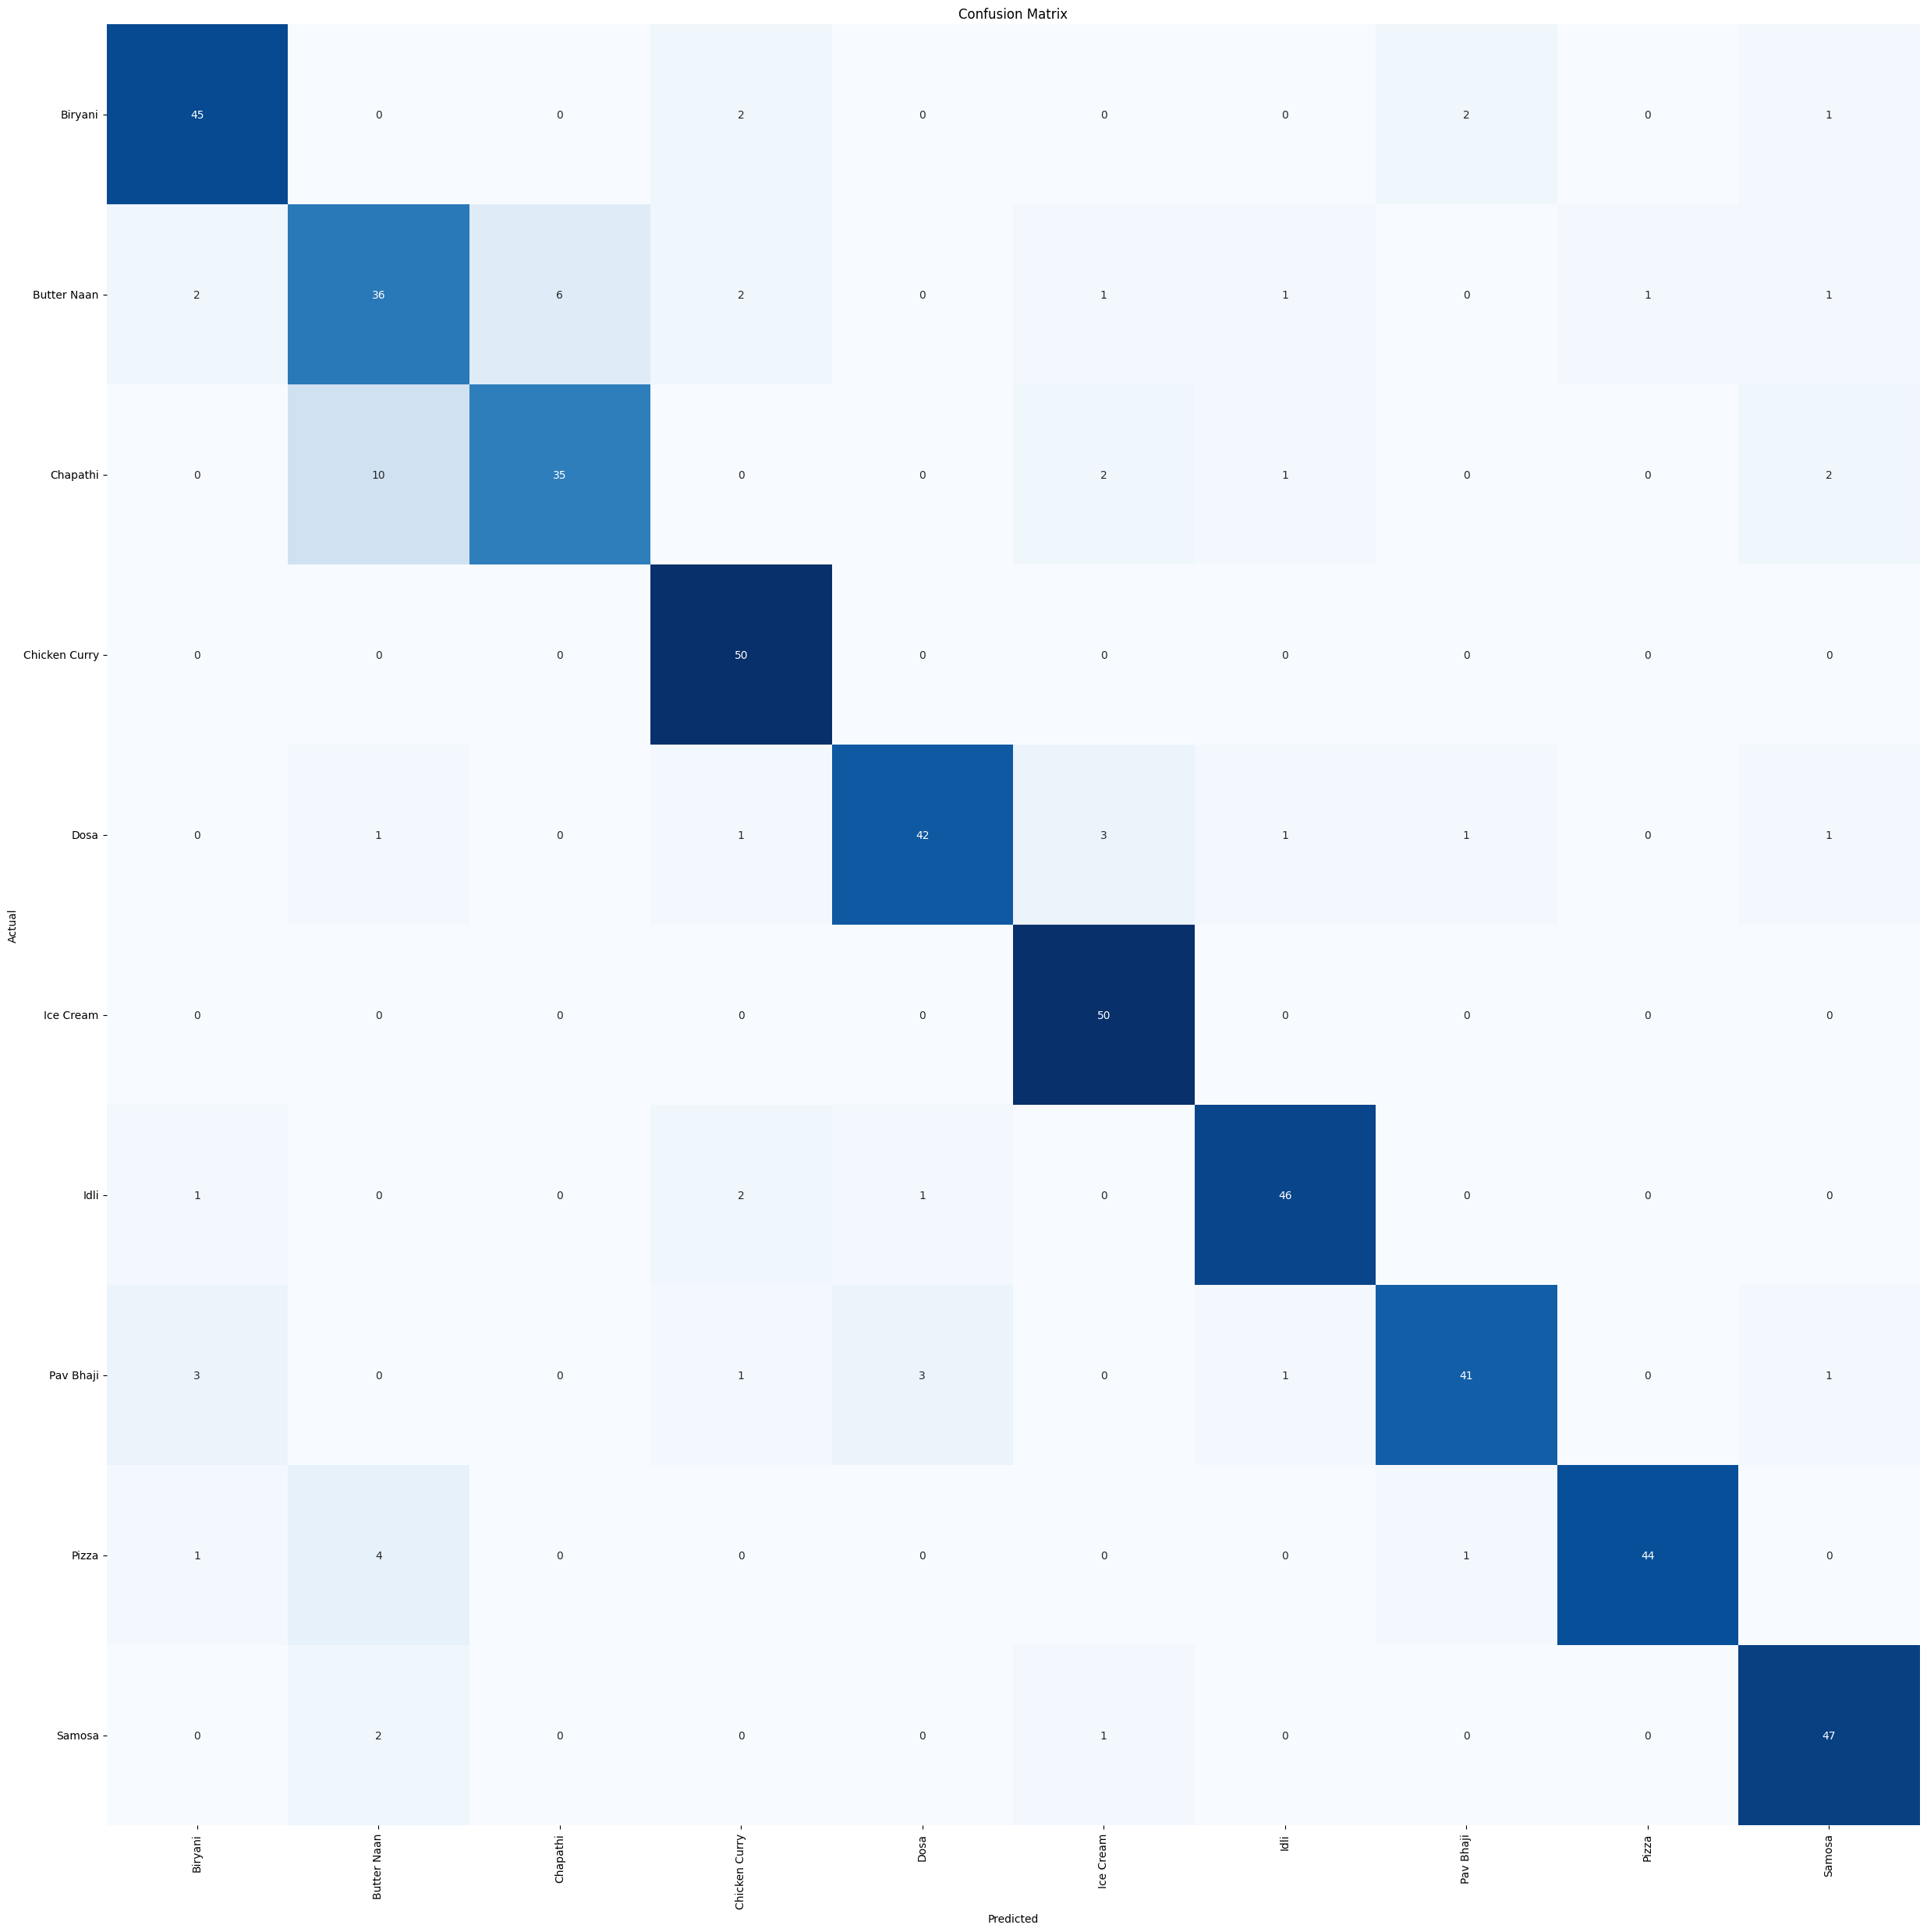

In [35]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(10) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(10) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [36]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

      Biryani       0.87      0.90      0.88        50
  Butter Naan       0.68      0.72      0.70        50
     Chapathi       0.85      0.70      0.77        50
Chicken Curry       0.86      1.00      0.93        50
         Dosa       0.91      0.84      0.87        50
    Ice Cream       0.88      1.00      0.93        50
         Idli       0.92      0.92      0.92        50
    Pav Bhaji       0.91      0.82      0.86        50
        Pizza       0.98      0.88      0.93        50
       Samosa       0.89      0.94      0.91        50

     accuracy                           0.87       500
    macro avg       0.87      0.87      0.87       500
 weighted avg       0.87      0.87      0.87       500



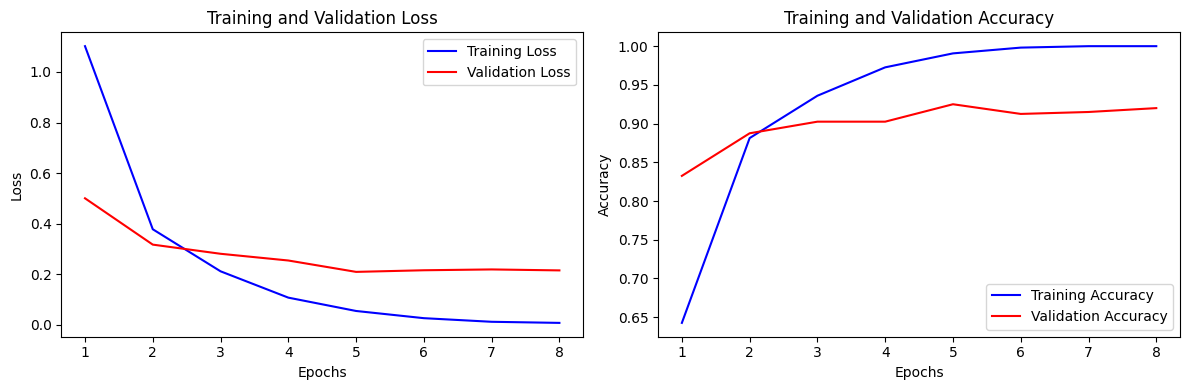

In [37]:
import matplotlib.pyplot as plt

# Extract the history data
history_dict = history.history

# Get training and validation accuracy and loss
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Define number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot Training and Validation Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


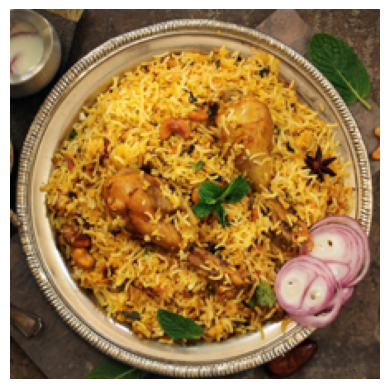

1/1 [==============================] - 1s 582ms/step
Predicted label: Biryani
There are  250 kcal in  1 plate (250 grams) of Biryani.


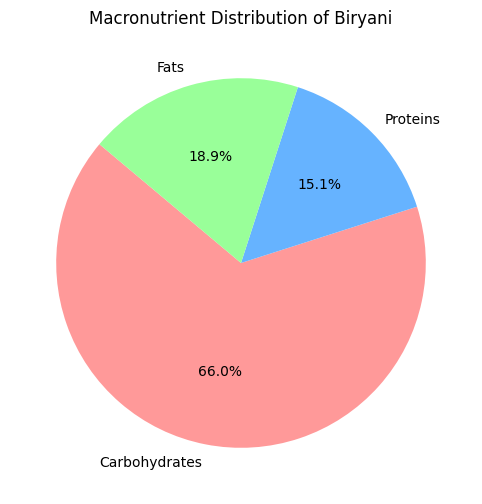

In [38]:
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt

# Load the calorie dataset
calorie_df = pd.read_csv('calorie_dataset.csv')

def predict_and_display_calories(img_path, model, calorie_df):
    # Load and display the image
    img = Image.open(img_path)
    img = img.resize((224, 224))

    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

    # Preprocess the image
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])

    # Reverse the class indices to get class labels
    class_indices = train_images.class_indices
    label_map = {v: k for k, v in class_indices.items()}
    predicted_label = label_map[predicted_class_index]

    # Fetch calorie information
    calorie_info = calorie_df[calorie_df['Label'] == predicted_label]

    if not calorie_info.empty:
        # Extract the information
        calorie_info_row = calorie_info.iloc[0]
        caloric_value = calorie_info_row['Caloric Value']
        carbohydrates = calorie_info_row['Carbohydrates']
        proteins = calorie_info_row['Proteins']
        fats = calorie_info_row['Fats']
        weight = calorie_info_row['Weight']

        print(f'Predicted label: {predicted_label}')
        print(f'There are {caloric_value} in {weight} of {predicted_label}.')

        # Pie chart for macronutrients
        labels = ['Carbohydrates', 'Proteins', 'Fats']
        sizes = [float(carbohydrates.split()[0]), float(proteins.split()[0]), float(fats.split()[0])]
        colors = ['#ff9999','#66b3ff','#99ff99']

        plt.figure(figsize=(8, 6))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.title(f'Macronutrient Distribution of {predicted_label}')
        plt.show()

    else:
        print(f'No calorie information found for label: {predicted_label}')

# Example usage
img_path = 'b.png'  # Replace with your image path
predict_and_display_calories(img_path, model, calorie_df)